In [1]:
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pickle

# Amazon Employee Access Challenge

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.shape

(32769, 10)

In [5]:
test.shape

(58921, 10)

In [6]:
y_train = train['ACTION']

In [7]:
y_train.shape

(32769,)

In [8]:
train_data = train.drop('ACTION', axis=1)
train_data.shape

(32769, 9)

In [9]:
test_data = test.drop('id', axis=1)
test_data.shape

(58921, 9)

## Common Variables

In [10]:
# define variables
random_state = 42
cv = 5
scoring = 'roc_auc'
verbose=2

## Common functions

In [11]:
def save_submission(predictions, filename):
    '''
    Save predictions into csv file
    '''
    global test
    submission = pd.DataFrame()
    submission["Id"] = test["id"]
    submission["ACTION"] = predictions
    filepath = "result/sampleSubmission_"+filename
    submission.to_csv(filepath, index = False)

In [12]:
def print_graph(results, param1, param2, xlabel, ylabel, title='Plot showing the ROC_AUC score for various hyper parameter values'):
    '''
    Plot the graph
    '''
    plt.plot(results[param1],results[param2]);
    plt.grid();
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);  

In [13]:
def get_rf_params():
    '''
    Return dictionary of parameters for random forest
    '''
    params = {
         'n_estimators':[10,20,50,100,200,500,700,1000],
         'max_depth':[1,2,5,10,12,15,20,25],
         'max_features':[1,2,3,4,5],
         'min_samples_split':[2,5,7,10,20]
    }

    return params

In [14]:
def get_xgb_params():
    '''
    Return dictionary of parameters for xgboost
    '''
    params = {
        'n_estimators': [10,20,50,100,200,500,750,1000],
        'learning_rate': uniform(0.01, 0.6),
        'subsample': uniform(),
        'max_depth': [3, 4, 5, 6, 7, 8, 9],
        'colsample_bytree': uniform(),
        'min_child_weight': [1, 2, 3, 4]
    }
    
    return params

### We will try following models

1. KNN
2. SVM
3. Logistic Regression
4. Random Forest
5. Xgboost

## Build Models on the raw data

## 1.1 KNN with raw features

In [15]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_data,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


In [16]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.083934,0.007898,0.265385,0.036920,1,{'n_neighbors': 1},0.613536,0.648565,0.631839,0.616312,0.612884,0.624627,0.013821,10
3,0.240013,0.066697,0.500296,0.106391,6,{'n_neighbors': 6},0.685658,0.705307,0.671377,0.682735,0.677139,0.684443,0.011522,1
7,0.226630,0.185183,0.727930,0.213502,16,{'n_neighbors': 16},0.682882,0.704267,0.671898,0.671661,0.688662,0.683874,0.012103,3
5,0.243259,0.052800,0.871988,0.100550,26,{'n_neighbors': 26},0.680836,0.702799,0.657414,0.686912,0.692020,0.683996,0.015120,2
4,0.183503,0.043958,0.783068,0.125342,41,{'n_neighbors': 41},0.679090,0.686315,0.660415,0.675779,0.679274,0.676175,0.008596,4
6,0.228750,0.048025,1.059379,0.235010,56,{'n_neighbors': 56},0.669826,0.680233,0.649829,0.677367,0.678156,0.671082,0.011194,5
2,0.311753,0.040799,1.216632,0.265773,76,{'n_neighbors': 76},0.661127,0.666859,0.647729,0.665512,0.667682,0.661782,0.007381,6
9,0.270957,0.199804,0.948423,0.458374,81,{'n_neighbors': 81},0.659469,0.661851,0.645727,0.664603,0.666253,0.659580,0.007305,7
1,0.168152,0.078784,1.293272,0.219475,86,{'n_neighbors': 86},0.660093,0.657713,0.645470,0.665596,0.662302,0.658235,0.006890,8
8,0.108329,0.024517,1.590826,0.059955,91,{'n_neighbors': 91},0.658300,0.655825,0.644015,0.663598,0.660646,0.656477,0.006740,9


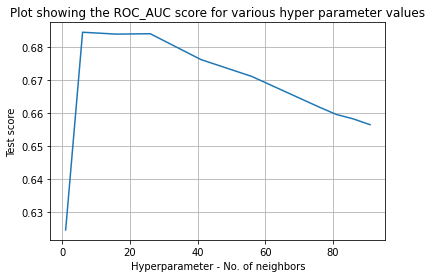

In [17]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [18]:
best_c=best_model.best_params_['n_neighbors']
best_c

6

In [19]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_data,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=6)

In [20]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, "knn_raw.csv")

![knn-raw](images/knn-raw-new.png)

## 1.2 SVM with raw feature

In [21]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_data,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [22]:
best_c=best_model.best_params_['C']
best_c

1.49816047538945

In [23]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,18.684481,0.499781,0.009284,0.000217,0.232334,{'C': 0.23233444867279784},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
5,19.870518,0.305372,0.009752,0.000904,0.623978,{'C': 0.6239780813448106},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
4,19.918902,0.358008,0.011202,0.001661,0.624075,{'C': 0.6240745617697461},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
0,19.442288,0.216182,0.009220,0.000190,1.49816,{'C': 1.49816047538945},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
3,19.357509,0.560751,0.009917,0.000562,2.39463,{'C': 2.3946339367881464},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
8,18.831271,0.356759,0.008356,0.001407,2.40446,{'C': 2.404460046972835},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
9,14.130057,5.223100,0.006211,0.001171,2.83229,{'C': 2.832290311184182},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
2,18.946967,0.453250,0.009577,0.000543,2.92798,{'C': 2.9279757672456204},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
7,18.603018,0.394303,0.009629,0.000678,3.4647,{'C': 3.4647045830997407},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
1,19.380741,0.234885,0.009244,0.000622,3.80286,{'C': 3.8028572256396647},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1


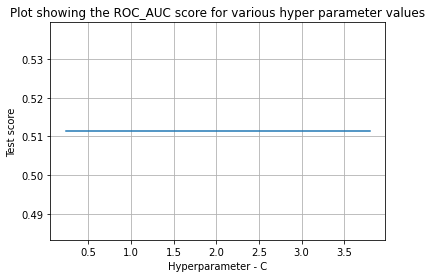

In [24]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [25]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_data,y_train)

[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC(C=1.49816047538945,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [26]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, 'svm_raw.csv')

![svm-raw](images/svm-raw.png)

## 1.3 Logistic Regression with Raw Feature

In [27]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_data,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [28]:
best_c=best_model.best_params_['C']
best_c

1.49816047538945

In [29]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.305453,0.042840,0.007123,0.001411,0.0220885,{'C': 0.022088468494409597},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
10,0.299544,0.043052,0.009865,0.001636,0.082338,{'C': 0.08233797718320979},0.519328,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,99
98,0.324737,0.029356,0.009632,0.001840,0.101677,{'C': 0.10167650697638075},0.519328,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,99
42,0.322684,0.047769,0.008097,0.001223,0.137554,{'C': 0.13755408446087358},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
58,0.312479,0.040692,0.010287,0.003491,0.180909,{'C': 0.18090915564215226},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.330116,0.064433,0.008579,0.001581,3.80286,{'C': 3.8028572256396647},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
34,0.307352,0.038496,0.009020,0.000806,3.86253,{'C': 3.8625281322982374},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
50,0.286139,0.050608,0.008554,0.001624,3.87834,{'C': 3.8783385110582342},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
11,0.311766,0.046068,0.009899,0.002444,3.87964,{'C': 3.8796394086479773},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1


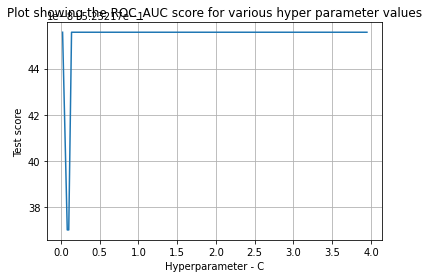

In [30]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [31]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_data,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(C=1.49816047538945, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [32]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, 'lr_raw.csv')

![lr-raw](images/lr-raw.png)

## 1.4 Random Forest with Raw Feature

In [33]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_data,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.1s
/home/auw-mayank/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.1min finished


In [34]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
78,700,25,2,7,0.864035
62,500,25,3,5,0.862868
79,500,25,1,10,0.861580
55,200,25,2,5,0.860777
22,200,25,4,10,0.860643
20,1000,25,3,2,0.860468
85,1000,20,3,7,0.860057
33,700,25,4,2,0.859027
84,1000,25,5,2,0.858752
27,50,25,2,10,0.858280


In [35]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(700, 2, 25, 7)

In [36]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_data,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=2,
                       min_samples_split=7, n_estimators=700, n_jobs=-1,
                       random_state=42)

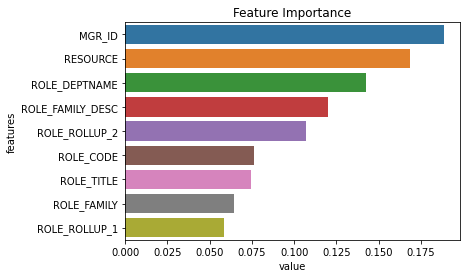

In [37]:
features=train_data.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

## Features Observations:

1. MGR_ID is the most important feature followed by RESOURCE and ROLE_DEPTNAME

In [38]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, 'rf_raw.csv')

![rf-raw](images/rf-raw.png)

## 1.5 Xgboost with Raw Feature

In [39]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_data,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.9min finished


In [40]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
18,1000,0.048135,0.665922,9,0.330898,2,0.859879
44,1000,0.060484,0.606429,6,0.642032,2,0.855594
97,750,0.232385,0.907694,6,0.374271,1,0.855062
96,500,0.0979629,0.98664,7,0.891897,1,0.854603
62,500,0.0663892,0.328153,9,0.375583,3,0.851305
49,500,0.160277,0.393098,8,0.636333,2,0.851109
84,200,0.571989,0.967581,6,0.348337,1,0.850137
53,200,0.540096,0.928319,6,0.27956,1,0.849858
86,1000,0.475848,0.858413,9,0.372018,2,0.849704
8,750,0.0686033,0.683264,6,0.304614,4,0.846364


In [41]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.3308980248526492, 0.04813501017161418, 9, 2, 1000, 0.6659223566174967)

In [42]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_data,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3308980248526492, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.04813501017161418, max_delta_step=0, max_depth=9,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6659223566174967, tree_method='exact',
              validate_parameters=1, verbosity=None)

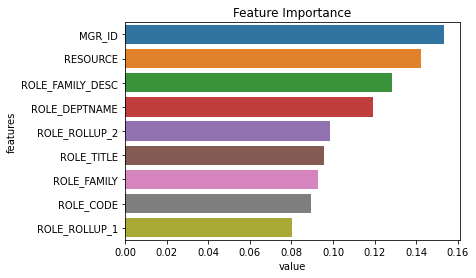

In [43]:
features=train_data.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [44]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, 'xgb_raw.csv')

![xgb-raw](images/xgb-raw.png)

![kaggle-submission-raw](images/kaggle-submission-raw.png)

In [45]:
from prettytable import PrettyTable

x = PrettyTable(['Model', 'Feature', 'Private Score', 'Public Score'])
x.add_row(['KNN','Raw', 0.67224, 0.68148])
x.add_row(['SVM', 'Raw', 0.50286, 0.51390])
x.add_row(['Logistic Regression', 'Raw', 0.53857, 0.53034])
x.add_row(['Random Forest', 'Raw', 0.87269, 0.87567])
x.add_row(['Xgboost', 'Raw', 0.86988, 0.87909])

print(x)

+---------------------+---------+---------------+--------------+
|        Model        | Feature | Private Score | Public Score |
+---------------------+---------+---------------+--------------+
|         KNN         |   Raw   |    0.67224    |   0.68148    |
|         SVM         |   Raw   |    0.50286    |    0.5139    |
| Logistic Regression |   Raw   |    0.53857    |   0.53034    |
|    Random Forest    |   Raw   |    0.87269    |   0.87567    |
|       Xgboost       |   Raw   |    0.86988    |   0.87909    |
+---------------------+---------+---------------+--------------+


# Observations:

1. Xgboost perform best on the raw features
2. Random forest also perform good on raw features
3. Tree based models performs better than linear models for raw features

## Build model on one hot encoded features

### 2.1 KNN with one hot encoded features

In [46]:
train_ohe = sparse.load_npz('data/train_ohe.npz')
test_ohe = sparse.load_npz('data/test_ohe.npz')

train_ohe.shape, test_ohe.shape, y_train.shape

((32769, 4500), (58921, 4500), (32769,))

In [47]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=4)
best_model = clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  3.2min finished


In [48]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008579,0.000699,12.889389,1.630046,1,{'n_neighbors': 1},0.637669,0.648976,0.623238,0.636597,0.657423,0.640781,0.011654,10
3,0.218653,0.141987,13.355838,1.399583,6,{'n_neighbors': 6},0.772541,0.817724,0.780078,0.764374,0.793066,0.785556,0.018651,7
7,0.014216,0.010986,11.480899,0.587346,16,{'n_neighbors': 16},0.799350,0.826579,0.798793,0.807640,0.819408,0.810354,0.011021,1
5,0.007408,0.000506,11.399296,0.072001,26,{'n_neighbors': 26},0.797242,0.823686,0.803639,0.801732,0.815795,0.808419,0.009798,2
4,0.029331,0.037009,11.730860,0.352833,41,{'n_neighbors': 41},0.793851,0.818524,0.801002,0.788353,0.802746,0.800895,0.010209,3
6,0.017152,0.013375,12.010613,0.940570,56,{'n_neighbors': 56},0.786070,0.817701,0.795020,0.780427,0.797255,0.795294,0.012744,4
2,0.325559,0.159848,31.339497,13.256170,76,{'n_neighbors': 76},0.787624,0.812770,0.781610,0.774486,0.792079,0.789714,0.012955,5
9,0.013539,0.006507,9.540637,2.054831,81,{'n_neighbors': 81},0.784840,0.807796,0.781348,0.773990,0.789062,0.787407,0.011329,6
1,0.103347,0.155776,24.211115,9.506957,86,{'n_neighbors': 86},0.781589,0.804704,0.778055,0.770839,0.784661,0.783969,0.011344,8
8,0.016657,0.008175,11.831052,0.749635,91,{'n_neighbors': 91},0.776625,0.803739,0.776098,0.768254,0.785209,0.781985,0.012129,9


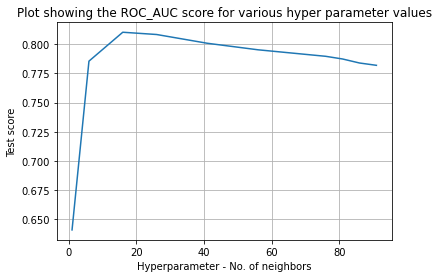

In [49]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [50]:
best_c=best_model.best_params_['n_neighbors']
best_c

16

In [51]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_ohe,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=16)

In [52]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, "knn_ohe.csv")

![knn-ohe](images/knn-ohe.png)

## 2.2 SVM with one hot encoded features

In [53]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.7s finished


[LibLinear]

In [54]:
best_c=best_model.best_params_['C']
best_c

0.23233444867279784

In [55]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,1.730894,0.069332,0.005605,0.000029,0.232334,{'C': 0.23233444867279784},0.875975,0.877388,0.868423,0.854196,0.876759,0.870548,0.008795,1
5,3.315943,0.201073,0.005879,0.000622,0.623978,{'C': 0.6239780813448106},0.863449,0.867204,0.859359,0.839469,0.866949,0.859286,0.010310,2
4,3.583880,0.365580,0.005711,0.000297,0.624075,{'C': 0.6240745617697461},0.863445,0.867202,0.859356,0.839466,0.866949,0.859284,0.010310,3
0,5.492834,0.287928,0.006418,0.000139,1.49816,{'C': 1.49816047538945},0.853168,0.859763,0.849378,0.826701,0.858361,0.849474,0.011976,4
3,4.961631,0.298074,0.005662,0.000146,2.39463,{'C': 2.3946339367881464},0.847499,0.855500,0.843579,0.820130,0.854114,0.844165,0.012780,5
8,4.833444,0.644881,0.004830,0.000888,2.40446,{'C': 2.404460046972835},0.847479,0.855422,0.843511,0.820026,0.854117,0.844111,0.012805,6
9,3.986315,0.360801,0.003652,0.000362,2.83229,{'C': 2.832290311184182},0.845397,0.853960,0.841066,0.817675,0.852844,0.842189,0.013150,7
2,4.873211,0.174700,0.006166,0.000985,2.92798,{'C': 2.9279757672456204},0.845317,0.853648,0.840564,0.817211,0.852536,0.841855,0.013222,8
7,4.817450,0.265487,0.005635,0.000099,3.4647,{'C': 3.4647045830997407},0.843165,0.852070,0.838012,0.815041,0.851000,0.839857,0.013443,9
1,4.685154,0.254005,0.006274,0.000241,3.80286,{'C': 3.8028572256396647},0.841944,0.851182,0.836607,0.813757,0.850197,0.838738,0.013602,10


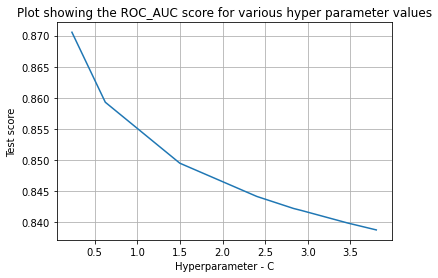

In [56]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [57]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_ohe,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.23233444867279784,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [58]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, 'svm_ohe.csv')

![svm-ohe](images/svm-ohe.png)

## 2.3 Logistic Regression with one hot encoded features

In [59]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


In [60]:
best_c=best_model.best_params_['C']
best_c

0.6820964947491661

In [61]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.439680,0.041474,0.006678,0.000959,0.0220885,{'C': 0.022088468494409597},0.829685,0.826673,0.806216,0.819296,0.846943,0.825763,0.013332,100
10,0.650064,0.051074,0.006208,0.001374,0.082338,{'C': 0.08233797718320979},0.865434,0.864914,0.844665,0.850616,0.871585,0.859443,0.010095,99
98,0.776743,0.046280,0.006456,0.000961,0.101677,{'C': 0.10167650697638075},0.869131,0.868748,0.848990,0.854158,0.874163,0.863038,0.009692,98
42,0.886947,0.055574,0.008943,0.003785,0.137554,{'C': 0.13755408446087358},0.873619,0.873387,0.854562,0.858294,0.877240,0.867420,0.009155,97
58,0.928974,0.072238,0.006947,0.000977,0.180909,{'C': 0.18090915564215226},0.876668,0.876799,0.858603,0.861092,0.879451,0.870523,0.008808,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2.534207,0.214963,0.006663,0.000782,3.80286,{'C': 3.8028572256396647},0.875063,0.877224,0.867324,0.852923,0.878666,0.870240,0.009502,92
34,2.376340,0.051137,0.006265,0.000269,3.86253,{'C': 3.8625281322982374},0.874952,0.877128,0.867242,0.852755,0.878560,0.870127,0.009524,93
50,2.498738,0.052591,0.007061,0.000964,3.87834,{'C': 3.8783385110582342},0.874918,0.877105,0.867222,0.852722,0.878531,0.870099,0.009525,94
11,2.401271,0.107580,0.006628,0.001671,3.87964,{'C': 3.8796394086479773},0.874916,0.877106,0.867214,0.852707,0.878524,0.870093,0.009530,95


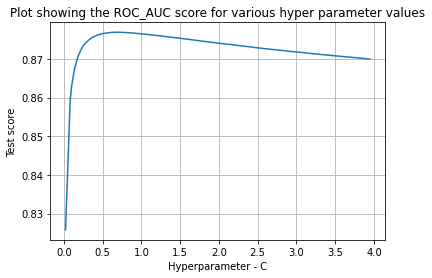

In [62]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [63]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_ohe,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


LogisticRegression(C=0.6820964947491661, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [64]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, 'lr_ohe.csv')

![lr-ohe](images/lr-ohe.png)

## 2.4 Random Forest with one hot encoded features

In [65]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.3min finished


In [66]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
78,700,25,2,7,0.860722
85,1000,20,3,7,0.855874
62,500,25,3,5,0.851481
6,500,20,2,5,0.850966
11,1000,15,3,7,0.849860
25,700,15,4,7,0.842645
19,700,15,4,5,0.841873
22,200,25,4,10,0.840912
79,500,25,1,10,0.840153
82,700,20,5,20,0.839475


In [67]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(700, 2, 25, 7)

In [68]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_ohe,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=2,
                       min_samples_split=7, n_estimators=700, n_jobs=-1,
                       random_state=42)

In [69]:
# features=train_ohe.columns
# importance=model.feature_importances_
# features=pd.DataFrame({'features':features,'value':importance})
# features=features.sort_values('value',ascending=False)
# sns.barplot('value','features',data=features);
# plt.title('Feature Importance');

In [70]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, 'rf_ohe.csv')

![rf-ohe](images/rf-ohe.png)

## 2.5 Xgboost with one hot encoded features

In [71]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.1min finished


In [72]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
97,750,0.232385,0.907694,6,0.374271,1,0.846718
80,1000,0.385564,0.905351,3,0.820639,1,0.845197
86,1000,0.475848,0.858413,9,0.372018,2,0.843883
84,200,0.571989,0.967581,6,0.348337,1,0.841967
14,200,0.374221,0.802197,7,0.965255,1,0.841475
50,500,0.388683,0.645103,4,0.892047,1,0.837885
53,200,0.540096,0.928319,6,0.27956,1,0.836996
92,200,0.478778,0.49442,9,0.946195,1,0.835709
96,500,0.0979629,0.98664,7,0.891897,1,0.835223
22,1000,0.391846,0.695516,6,0.0314292,1,0.833849


In [73]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.3742707957561203, 0.23238528824013455, 6, 1, 750, 0.9076937063485463)

In [74]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_ohe,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3742707957561203, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.23238528824013455, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9076937063485463, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [75]:
# features=train_ohe.columns
# importance=model.feature_importances_
# features=pd.DataFrame({'features':features,'value':importance})
# features=features.sort_values('value',ascending=False)
# sns.barplot('value','features',data=features);
# plt.title('Feature Importance');

In [76]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, 'xgb_ohe.csv')

![xgb-ohe](images/xgb-ohe.png)

![kaggle-submission-ohe](images/kaggle-submission-ohe.png)

In [77]:
from prettytable import PrettyTable

x = PrettyTable(['Model', 'Feature', 'Private Score', 'Public Score'])
x.add_row(['KNN','ohe', 0.81657, 0.81723])
x.add_row(['SVM', 'ohe', 0.87249, 0.87955])
x.add_row(['Logistic Regression', 'ohe', 0.87436, 0.88167])
x.add_row(['Random Forest', 'ohe', 0.84541, 0.84997])
x.add_row(['Xgboost', 'ohe', 0.84717, 0.85102])

print(x)

+---------------------+---------+---------------+--------------+
|        Model        | Feature | Private Score | Public Score |
+---------------------+---------+---------------+--------------+
|         KNN         |   ohe   |    0.81657    |   0.81723    |
|         SVM         |   ohe   |    0.87249    |   0.87955    |
| Logistic Regression |   ohe   |    0.87436    |   0.88167    |
|    Random Forest    |   ohe   |    0.84541    |   0.84997    |
|       Xgboost       |   ohe   |    0.84717    |   0.85102    |
+---------------------+---------+---------------+--------------+


# Observations:

1. One hot encoding features performs better than other encoding technique
2. Linear models (Logistic Regression and SVM) performs better on higher dimension

# 3 Build Model on frequency encoding feature

## 3.1 KNN with frequency encoding

In [78]:
train_df_fc = pd.read_csv('data/train_df_fc.csv')
test_df_fc = pd.read_csv('data/test_df_fc.csv')

In [79]:
train_df_fc.shape, test_df_fc.shape, y_train.shape

((32769, 9), (58921, 9), (32769,))

In [80]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.4s finished


In [81]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.245504,0.191884,0.444588,0.057236,1,{'n_neighbors': 1},0.689830,0.699702,0.672487,0.691981,0.683082,0.687416,0.009157,10
3,0.966955,0.192374,0.425104,0.082150,6,{'n_neighbors': 6},0.782603,0.801378,0.779351,0.785807,0.789640,0.787756,0.007617,2
7,0.915347,0.088786,0.510648,0.062272,16,{'n_neighbors': 16},0.780617,0.810798,0.788244,0.793029,0.784501,0.791438,0.010514,1
5,0.910787,0.067158,0.587300,0.075423,26,{'n_neighbors': 26},0.784436,0.799879,0.773578,0.792340,0.781795,0.786406,0.009016,3
4,0.867675,0.145174,0.647190,0.063128,41,{'n_neighbors': 41},0.764873,0.782251,0.762178,0.783043,0.763852,0.771240,0.009357,4
6,0.877225,0.208047,0.709570,0.113621,56,{'n_neighbors': 56},0.749887,0.769348,0.757223,0.767120,0.757640,0.760244,0.007118,5
2,0.947447,0.128830,0.768725,0.107211,76,{'n_neighbors': 76},0.735012,0.749768,0.748032,0.750562,0.756848,0.748045,0.007165,6
9,0.934347,0.100315,0.597521,0.257969,81,{'n_neighbors': 81},0.733258,0.745024,0.744657,0.746431,0.756481,0.745170,0.007372,7
1,1.011318,0.326486,0.772521,0.073501,86,{'n_neighbors': 86},0.731535,0.740285,0.741123,0.741903,0.755343,0.742038,0.007632,8
8,0.832900,0.196410,0.861454,0.065058,91,{'n_neighbors': 91},0.730638,0.735961,0.738581,0.739851,0.753802,0.739767,0.007697,9


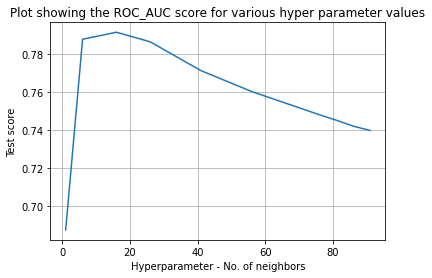

In [82]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [83]:
best_c=best_model.best_params_['n_neighbors']
best_c

16

In [84]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_df_fc,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=16)

In [85]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, "knn_fc.csv")

![knn-fc](images/knn-fc.png)

## 3.2 SVM with frequency encoding

In [86]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.9s finished


[LibLinear]

In [87]:
best_c=best_model.best_params_['C']
best_c

3.4647045830997407

In [88]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.707697,0.038330,0.009112,0.000330,0.232334,{'C': 0.23233444867279784},0.596242,0.592806,0.589267,0.589870,0.616262,0.596889,0.009998,10
5,1.619894,0.069040,0.009326,0.000816,0.623978,{'C': 0.6239780813448106},0.598835,0.598629,0.594103,0.590754,0.618887,0.600242,0.009797,8
4,1.579539,0.025513,0.008887,0.000250,0.624075,{'C': 0.6240745617697461},0.598836,0.598628,0.594102,0.590755,0.618887,0.600242,0.009797,9
0,3.577643,0.097967,0.009332,0.000580,1.49816,{'C': 1.49816047538945},0.599720,0.603314,0.596806,0.590896,0.619533,0.602054,0.009639,7
3,5.732613,0.118254,0.009076,0.000258,2.39463,{'C': 2.3946339367881464},0.599911,0.604767,0.597368,0.590228,0.619655,0.602386,0.009829,5
8,5.664490,0.136819,0.009409,0.001280,2.40446,{'C': 2.404460046972835},0.599903,0.604776,0.597367,0.590224,0.619659,0.602386,0.009832,6
9,5.364426,0.630964,0.005462,0.000641,2.83229,{'C': 2.832290311184182},0.600041,0.605195,0.597402,0.590054,0.619668,0.602472,0.009889,4
2,6.995208,0.140802,0.009158,0.000407,2.92798,{'C': 2.9279757672456204},0.600091,0.605287,0.597393,0.590013,0.619653,0.602487,0.009897,3
7,8.412424,0.706659,0.009016,0.000114,3.4647,{'C': 3.4647045830997407},0.600137,0.605531,0.597598,0.589721,0.619510,0.602500,0.009914,1
1,9.626733,0.661829,0.008899,0.000069,3.80286,{'C': 3.8028572256396647},0.600128,0.605674,0.597598,0.589540,0.619514,0.602491,0.009972,2


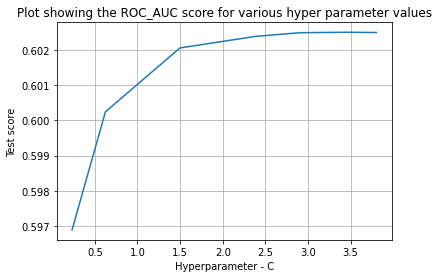

In [89]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [90]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_df_fc,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

CalibratedClassifierCV(base_estimator=LinearSVC(C=3.4647045830997407,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [91]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, 'svm_fc.csv')

![svm-fc](images/svm-fc.png)

## 3.3 Logistic Regression with frequency encoding

In [92]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [93]:
best_c=best_model.best_params_['C']
best_c

3.947547746402069

In [94]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.182546,0.056575,0.010424,0.001924,0.0220885,{'C': 0.022088468494409597},0.572784,0.564601,0.561810,0.579600,0.592248,0.574209,0.010978,100
10,0.230978,0.011034,0.010079,0.002740,0.082338,{'C': 0.08233797718320979},0.576081,0.570211,0.569417,0.584004,0.590101,0.577963,0.008006,99
98,0.246538,0.040240,0.008149,0.000789,0.101677,{'C': 0.10167650697638075},0.578311,0.571484,0.571928,0.586633,0.590390,0.579749,0.007644,98
42,0.264855,0.051649,0.007584,0.001100,0.137554,{'C': 0.13755408446087358},0.581972,0.574516,0.576192,0.590778,0.591770,0.583046,0.007166,97
58,0.294973,0.058159,0.009848,0.001887,0.180909,{'C': 0.18090915564215226},0.586059,0.577597,0.579853,0.593481,0.593861,0.586170,0.006723,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.544588,0.077972,0.010987,0.002171,3.80286,{'C': 3.8028572256396647},0.597920,0.597220,0.592827,0.590501,0.618289,0.599351,0.009860,5
34,0.517311,0.047540,0.010529,0.004522,3.86253,{'C': 3.8625281322982374},0.597984,0.597303,0.592888,0.590481,0.618319,0.599395,0.009862,4
50,0.546014,0.078366,0.011045,0.001893,3.87834,{'C': 3.8783385110582342},0.597974,0.597336,0.592937,0.590487,0.618339,0.599415,0.009861,3
11,0.487671,0.048548,0.010200,0.002548,3.87964,{'C': 3.8796394086479773},0.598001,0.597354,0.592944,0.590463,0.618329,0.599418,0.009859,2


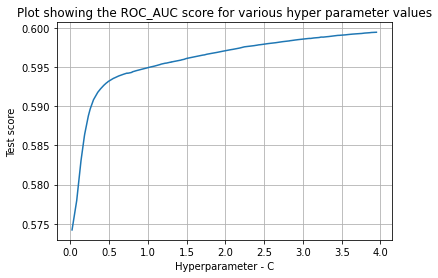

In [95]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [96]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_df_fc,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


LogisticRegression(C=3.947547746402069, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [97]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, 'lr_fc.csv')

![lr-fc](images/lr-fc.png)

## 3.4 Random Forest with frequency encoding

In [98]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.3min
/home/auw-mayank/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.3min finished


In [99]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
78,700,25,2,7,0.865455
79,500,25,1,10,0.863705
85,1000,20,3,7,0.863124
55,200,25,2,5,0.862765
27,50,25,2,10,0.862614
62,500,25,3,5,0.862305
22,200,25,4,10,0.862144
6,500,20,2,5,0.860599
76,50,25,1,5,0.859857
84,1000,25,5,2,0.859026


In [100]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(700, 2, 25, 7)

In [101]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_df_fc,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=2,
                       min_samples_split=7, n_estimators=700, n_jobs=-1,
                       random_state=42)

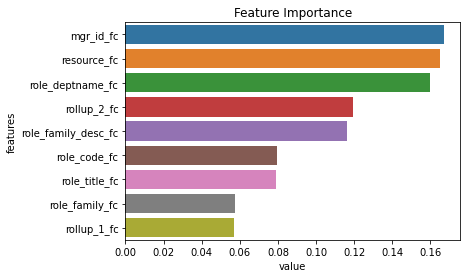

In [103]:
features=train_df_fc.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [106]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, 'rf_fc.csv')

![rf-fc](images/rf-fc.png)

## 3.5 Xgboost with frequency encoding

In [107]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.3min finished


In [108]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
18,1000,0.048135,0.665922,9,0.330898,2,0.858830
96,500,0.0979629,0.98664,7,0.891897,1,0.857160
44,1000,0.060484,0.606429,6,0.642032,2,0.854864
97,750,0.232385,0.907694,6,0.374271,1,0.854471
86,1000,0.475848,0.858413,9,0.372018,2,0.852575
53,200,0.540096,0.928319,6,0.27956,1,0.851643
84,200,0.571989,0.967581,6,0.348337,1,0.850900
49,500,0.160277,0.393098,8,0.636333,2,0.850151
62,500,0.0663892,0.328153,9,0.375583,3,0.848839
14,200,0.374221,0.802197,7,0.965255,1,0.846264


In [109]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.3308980248526492, 0.04813501017161418, 9, 2, 1000, 0.6659223566174967)

In [110]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_df_fc,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3308980248526492, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.04813501017161418, max_delta_step=0, max_depth=9,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6659223566174967, tree_method='exact',
              validate_parameters=1, verbosity=None)

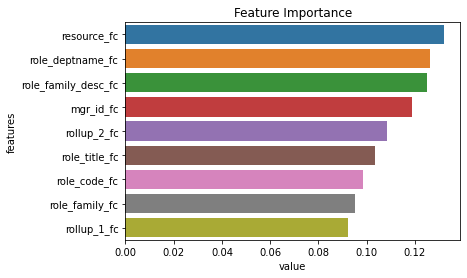

In [111]:
features=train_df_fc.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [112]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, 'xgb_fc.csv')

![xgb-fc](images/xgb-fc.png)

![kaggle-submission-fc](images/kaggle-submission-fc.png)

In [113]:
from prettytable import PrettyTable

x = PrettyTable(['Model', 'Feature', 'Private Score', 'Public Score'])
x.add_row(['KNN','fc', 0.79715, 0.79125])
x.add_row(['SVM', 'fc', 0.60085, 0.59550])
x.add_row(['Logistic Regression', 'fc', 0.59896, 0.59778])
x.add_row(['Random Forest', 'fc', 0.87299, 0.87616])
x.add_row(['Xgboost', 'fc', 0.86987, 0.86944])

print(x)

+---------------------+---------+---------------+--------------+
|        Model        | Feature | Private Score | Public Score |
+---------------------+---------+---------------+--------------+
|         KNN         |    fc   |    0.79715    |   0.79125    |
|         SVM         |    fc   |    0.60085    |    0.5955    |
| Logistic Regression |    fc   |    0.59896    |   0.59778    |
|    Random Forest    |    fc   |    0.87299    |   0.87616    |
|       Xgboost       |    fc   |    0.86987    |   0.86944    |
+---------------------+---------+---------------+--------------+


# Observations:

1. Tree based models performs better for this feature than linear models
2. KNN is doing good for every feature

# 4 Build Model using response encoding feature

In [114]:
train_df_rc = pd.read_csv('data/train_df_rc.csv')
test_df_rc = pd.read_csv('data/test_df_rc.csv')

In [115]:
train_df_rc.shape, test_df_rc.shape, y_train.shape

((32769, 9), (58921, 9), (32769,))

## 4.1 KNN with response encoding

In [116]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.7s finished


In [117]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.087703,0.003754,0.270912,0.118324,1,{'n_neighbors': 1},0.785764,0.803724,0.775463,0.779148,0.764597,0.781739,0.012958,10
3,0.161678,0.063581,0.749612,0.191282,6,{'n_neighbors': 6},0.913267,0.929281,0.912042,0.938589,0.930850,0.924806,0.010417,9
7,0.365460,0.149200,1.097595,0.234131,16,{'n_neighbors': 16},0.947662,0.957579,0.950075,0.960931,0.948791,0.953008,0.005266,8
5,0.274667,0.128723,1.106008,0.062541,26,{'n_neighbors': 26},0.960510,0.965995,0.956449,0.965414,0.956676,0.961009,0.004101,7
4,0.196924,0.091312,1.247186,0.043935,41,{'n_neighbors': 41},0.967694,0.970531,0.961577,0.970235,0.962889,0.966585,0.003711,6
6,0.121391,0.037696,1.616742,0.078125,56,{'n_neighbors': 56},0.968329,0.971504,0.963187,0.970208,0.966776,0.968001,0.002896,5
2,0.257782,0.047633,1.718469,0.251959,76,{'n_neighbors': 76},0.969092,0.970238,0.965122,0.970237,0.968003,0.968538,0.001900,3
9,0.259518,0.169725,1.463110,0.571909,81,{'n_neighbors': 81},0.969085,0.970350,0.964951,0.969905,0.967942,0.968447,0.001930,4
1,0.166987,0.110239,2.083340,0.073632,86,{'n_neighbors': 86},0.968902,0.971091,0.965033,0.969832,0.967886,0.968549,0.002051,2
8,0.215055,0.138284,2.578594,0.120702,91,{'n_neighbors': 91},0.968775,0.970906,0.964625,0.970507,0.968111,0.968585,0.002237,1


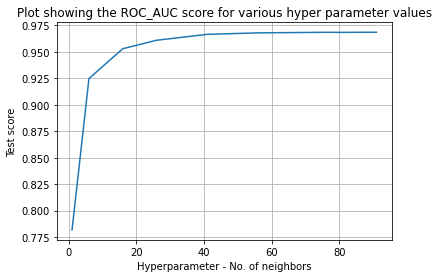

In [118]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [119]:
best_c=best_model.best_params_['n_neighbors']
best_c

91

In [120]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_df_rc,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=91)

In [121]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, "knn_rc.csv")

![knn-rc](images/knn-rc.png)

## 4.2 SVM with response encoding

In [122]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


[LibLinear]

In [123]:
best_c=best_model.best_params_['C']
best_c

0.23233444867279784

In [124]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,3.726326,0.130475,0.009511,0.000833,0.232334,{'C': 0.23233444867279784},0.962693,0.968227,0.956840,0.961949,0.960551,0.962052,0.003687,1
5,9.815611,0.452051,0.009016,0.000450,0.623978,{'C': 0.6239780813448106},0.962731,0.968228,0.956767,0.961982,0.960510,0.962044,0.003713,3
4,9.402443,0.604710,0.009335,0.000597,0.624075,{'C': 0.6240745617697461},0.962731,0.968228,0.956767,0.961982,0.960510,0.962044,0.003713,2
0,20.009992,0.735768,0.009698,0.000943,1.49816,{'C': 1.49816047538945},0.962746,0.968237,0.956698,0.962003,0.960470,0.962031,0.003739,5
3,19.451480,0.384670,0.013516,0.008621,2.39463,{'C': 2.3946339367881464},0.962758,0.968233,0.956696,0.962007,0.960461,0.962031,0.003739,4
8,17.116975,1.498897,0.008659,0.001653,2.40446,{'C': 2.404460046972835},0.962758,0.968232,0.956696,0.962007,0.960461,0.962031,0.003739,6
9,14.348889,1.305182,0.005841,0.001067,2.83229,{'C': 2.832290311184182},0.962760,0.968226,0.956688,0.962006,0.960461,0.962028,0.003740,7
2,19.717969,0.395682,0.010328,0.002716,2.92798,{'C': 2.9279757672456204},0.962761,0.968228,0.956687,0.962003,0.960458,0.962027,0.003741,9
7,18.970401,0.625358,0.009083,0.000206,3.4647,{'C': 3.4647045830997407},0.962761,0.968228,0.956687,0.962009,0.960453,0.962028,0.003741,8
1,20.206970,0.710743,0.009152,0.000238,3.80286,{'C': 3.8028572256396647},0.962760,0.968227,0.956680,0.962013,0.960450,0.962026,0.003743,10


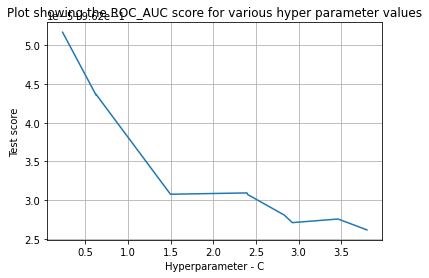

In [125]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [126]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_df_rc,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.23233444867279784,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [127]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, 'svm_rc.csv')

![svm-rc](images/svm-rc.png)

## 4.3 Logistic Regression with response encoding

In [128]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [129]:
best_c=best_model.best_params_['C']
best_c

3.8783385110582342

In [130]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.419037,0.018913,0.014351,0.004590,0.0220885,{'C': 0.022088468494409597},0.961174,0.966541,0.953542,0.960469,0.958646,0.960074,0.004193,100
10,0.377327,0.053768,0.012779,0.002567,0.082338,{'C': 0.08233797718320979},0.962000,0.967349,0.954943,0.961462,0.959433,0.961037,0.004016,99
98,0.375209,0.049318,0.010560,0.000751,0.101677,{'C': 0.10167650697638075},0.962099,0.967475,0.955163,0.961613,0.959566,0.961183,0.003987,98
42,0.392769,0.045860,0.014432,0.004220,0.137554,{'C': 0.13755408446087358},0.962232,0.967616,0.955462,0.961811,0.959706,0.961365,0.003940,97
58,0.438569,0.077177,0.013336,0.003642,0.180909,{'C': 0.18090915564215226},0.962303,0.967719,0.955701,0.961930,0.959816,0.961494,0.003898,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.506320,0.115184,0.009774,0.001500,3.80286,{'C': 3.8028572256396647},0.962708,0.968389,0.956652,0.962017,0.960447,0.962042,0.003803,2
34,0.435505,0.063518,0.010841,0.001308,3.86253,{'C': 3.8625281322982374},0.962709,0.968388,0.956649,0.962019,0.960447,0.962042,0.003804,3
50,0.560126,0.144761,0.012199,0.003007,3.87834,{'C': 3.8783385110582342},0.962709,0.968387,0.956652,0.962019,0.960449,0.962043,0.003803,1
11,0.493065,0.118567,0.013844,0.004191,3.87964,{'C': 3.8796394086479773},0.962705,0.968389,0.956641,0.962018,0.960449,0.962040,0.003806,7


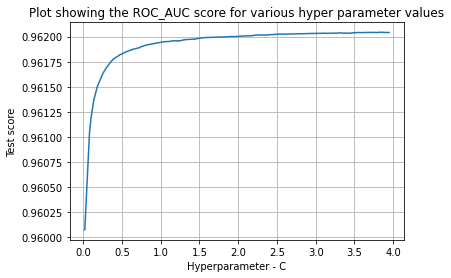

In [131]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [132]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_df_rc,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


LogisticRegression(C=3.8783385110582342, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [133]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, 'lr_rc.csv')

![lr-rc](images/lr-rc.png)

## 4.4 Random Forest with response encoding

In [134]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.3min finished


In [135]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
68,1000,10,4,20,0.978213
26,700,12,4,20,0.978080
64,700,10,5,7,0.977829
82,700,20,5,20,0.977748
41,500,10,3,7,0.977430
96,100,10,3,10,0.977397
87,200,10,5,2,0.977377
11,1000,15,3,7,0.977211
85,1000,20,3,7,0.977043
25,700,15,4,7,0.976876


In [136]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(1000, 4, 10, 20)

In [137]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_df_rc,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=4,
                       min_samples_split=20, n_estimators=1000, n_jobs=-1,
                       random_state=42)

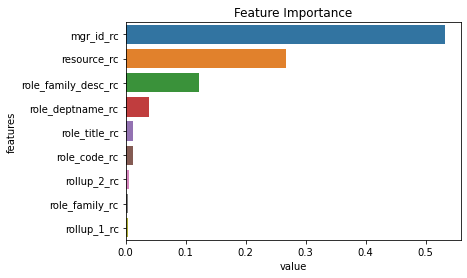

In [138]:
features=train_df_rc.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [139]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, 'rf_rc.csv')

![rf-rc](images/rf-rc.png)

## 4.5 Xgboost with response encoding

In [140]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.7min finished


In [141]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
1,200,0.0699849,0.601115,5,0.445833,4,0.980332
28,500,0.0141713,0.222108,5,0.860731,1,0.980097
7,500,0.017959,0.808397,3,0.450499,4,0.980070
98,50,0.220131,0.777147,6,0.591889,3,0.979997
41,20,0.34312,0.996254,6,0.817222,1,0.979949
58,50,0.454461,0.708911,3,0.877373,1,0.979929
33,100,0.153737,0.447783,4,0.908266,1,0.979679
74,20,0.432195,0.763364,6,0.855461,4,0.979671
94,20,0.591191,0.618218,3,0.705831,2,0.979554
88,200,0.307937,0.895523,3,0.534327,2,0.979545


In [142]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.44583275285359114, 0.06998494949080172, 5, 4, 200, 0.6011150117432088)

In [143]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_df_rc,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.44583275285359114, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.06998494949080172, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6011150117432088, tree_method='exact',
              validate_parameters=1, verbosity=None)

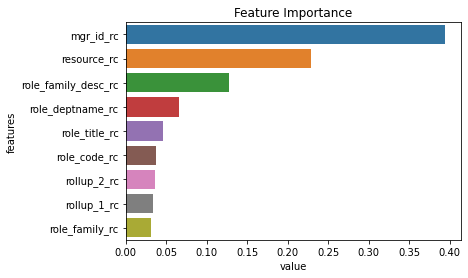

In [144]:
features=train_df_rc.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [145]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, 'xgb_rc.csv')

![xgb-rc](images/xgb-rc.png)

![kaggle-submission-rc](images/kaggle-submission-rc.png)

In [146]:
from prettytable import PrettyTable

x = PrettyTable(['Model', 'Feature', 'Private Score', 'Public Score'])
x.add_row(['KNN','rc', 0.84352, 0.85351])
x.add_row(['SVM', 'rc', 0.85160, 0.86031])
x.add_row(['Logistic Regression', 'rc', 0.85322, 0.86180])
x.add_row(['Random Forest', 'rc', 0.83136, 0.83892])
x.add_row(['Xgboost', 'rc', 0.84135, 0.84190])

print(x)

+---------------------+---------+---------------+--------------+
|        Model        | Feature | Private Score | Public Score |
+---------------------+---------+---------------+--------------+
|         KNN         |    rc   |    0.84352    |   0.85351    |
|         SVM         |    rc   |     0.8516    |   0.86031    |
| Logistic Regression |    rc   |    0.85322    |    0.8618    |
|    Random Forest    |    rc   |    0.83136    |   0.83892    |
|       Xgboost       |    rc   |    0.84135    |    0.8419    |
+---------------------+---------+---------------+--------------+


# Observations:

1. Every model performs good for this feature
2. Linear models performs better than Tree based models

# 5 Build model on SVD feature

In [147]:
train_svd = pd.read_csv('data/train_svd.csv')
test_svd = pd.read_csv('data/test_svd.csv')

In [148]:
train_svd.shape, test_svd.shape, y_train.shape

((32769, 72), (58921, 72), (32769,))

## 5.1 KNN with SVD

In [149]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_svd,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.0s finished


In [150]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.526564,0.011169,1.004034,0.149404,1,{'n_neighbors': 1},0.683686,0.708752,0.711678,0.695199,0.688302,0.697523,0.011030,10
3,1.944336,0.551025,1.655248,0.153292,6,{'n_neighbors': 6},0.774836,0.790142,0.790174,0.802106,0.796821,0.790816,0.009162,1
7,2.016851,0.954735,3.149633,0.351339,16,{'n_neighbors': 16},0.775776,0.805809,0.785608,0.791553,0.781162,0.787981,0.010312,2
5,2.240037,0.818733,3.354217,0.898707,26,{'n_neighbors': 26},0.767621,0.787773,0.778761,0.774628,0.773609,0.776478,0.006677,3
4,1.967969,0.228458,3.715187,1.218701,41,{'n_neighbors': 41},0.756356,0.776811,0.769727,0.761724,0.757368,0.764398,0.007794,4
6,1.281747,0.189357,5.637847,0.125865,56,{'n_neighbors': 56},0.748039,0.760013,0.760727,0.752137,0.751543,0.754492,0.005005,5
2,2.475243,0.578326,5.100802,0.859254,76,{'n_neighbors': 76},0.732281,0.737831,0.753871,0.732209,0.742187,0.739676,0.008021,6
9,2.189955,1.122140,3.499732,1.791585,81,{'n_neighbors': 81},0.730612,0.731773,0.751814,0.731879,0.743131,0.737842,0.008341,7
1,1.204084,0.808660,5.773037,0.319467,86,{'n_neighbors': 86},0.728424,0.728917,0.747933,0.731289,0.745360,0.736385,0.008474,8
8,0.703830,0.153865,7.607220,0.172469,91,{'n_neighbors': 91},0.724298,0.725631,0.742431,0.728516,0.744969,0.733169,0.008743,9


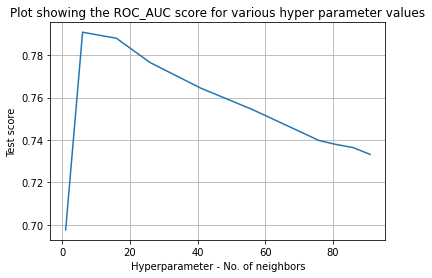

In [151]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [152]:
best_c=best_model.best_params_['n_neighbors']
best_c

6

In [153]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_svd,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=6)

In [154]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, "knn_svd.csv")

![knn-svd](images/knn-svd.png)

## 5.2 SVM with SVD

In [155]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_svd,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


[LibLinear]

In [156]:
best_c=best_model.best_params_['C']
best_c

3.8028572256396647

In [157]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,2.968880,0.150177,0.016558,0.002776,0.232334,{'C': 0.23233444867279784},0.634839,0.636558,0.625390,0.631673,0.648453,0.635383,0.007565,10
5,6.587434,0.301619,0.012963,0.000876,0.623978,{'C': 0.6239780813448106},0.640705,0.639460,0.626744,0.635352,0.651394,0.638731,0.007999,9
4,6.343227,0.065596,0.012513,0.000442,0.624075,{'C': 0.6240745617697461},0.640705,0.639463,0.626747,0.635353,0.651395,0.638732,0.007998,8
0,17.291072,1.080804,0.016185,0.007285,1.49816,{'C': 1.49816047538945},0.645319,0.641522,0.628096,0.639863,0.652860,0.641532,0.008075,7
3,29.455153,0.767611,0.015290,0.003827,2.39463,{'C': 2.3946339367881464},0.646977,0.641498,0.628038,0.641603,0.653376,0.642298,0.008356,6
8,29.985117,1.952692,0.012303,0.002009,2.40446,{'C': 2.404460046972835},0.646977,0.641494,0.628043,0.641614,0.653371,0.642300,0.008353,5
9,27.816009,2.354661,0.007257,0.000748,2.83229,{'C': 2.832290311184182},0.647186,0.641545,0.627889,0.641841,0.653459,0.642384,0.008448,4
2,36.411890,2.210566,0.012634,0.000489,2.92798,{'C': 2.9279757672456204},0.647245,0.641560,0.627827,0.641863,0.653489,0.642397,0.008483,3
7,44.704208,1.334583,0.012921,0.000702,3.4647,{'C': 3.4647045830997407},0.647549,0.641669,0.627698,0.642045,0.653490,0.642490,0.008559,2
1,48.909459,2.384907,0.016626,0.005413,3.80286,{'C': 3.8028572256396647},0.647759,0.641743,0.627645,0.642088,0.653549,0.642557,0.008615,1


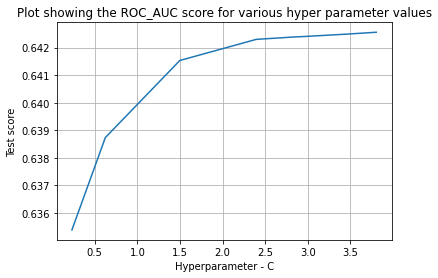

In [158]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [159]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_svd,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

CalibratedClassifierCV(base_estimator=LinearSVC(C=3.8028572256396647,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [160]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, 'svm_svd.csv')

![svm-svd](images/svm-svd.png)

## 5.3 Logistic Regression with SVD

In [161]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_svd,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished


In [162]:
best_c=best_model.best_params_['C']
best_c

3.947547746402069

In [163]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,1.042337,0.102578,0.035350,0.017093,0.0220885,{'C': 0.022088468494409597},0.604873,0.600333,0.602393,0.608164,0.630087,0.609170,0.010780,100
10,1.598916,0.145812,0.029739,0.011829,0.082338,{'C': 0.08233797718320979},0.618172,0.619258,0.615257,0.617055,0.637928,0.621534,0.008303,99
98,1.946853,0.134926,0.031715,0.005840,0.101677,{'C': 0.10167650697638075},0.619889,0.622181,0.615896,0.618293,0.639096,0.623071,0.008271,98
42,1.629183,0.083901,0.022801,0.003346,0.137554,{'C': 0.13755408446087358},0.621979,0.625304,0.617100,0.620475,0.640221,0.625016,0.008047,97
58,1.859177,0.136240,0.025097,0.007581,0.180909,{'C': 0.18090915564215226},0.624074,0.627986,0.618850,0.621867,0.641453,0.626846,0.007888,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,7.015733,0.438911,0.026228,0.005973,3.80286,{'C': 3.8028572256396647},0.639070,0.639976,0.625161,0.635001,0.650478,0.637937,0.008180,5
34,6.146194,0.345854,0.028273,0.008512,3.86253,{'C': 3.8625281322982374},0.639170,0.640006,0.625275,0.635038,0.650431,0.637984,0.008132,3
50,6.477816,0.289469,0.026133,0.013208,3.87834,{'C': 3.8783385110582342},0.639168,0.639948,0.625290,0.635046,0.650405,0.637972,0.008115,4
11,6.560687,0.689193,0.033242,0.007402,3.87964,{'C': 3.8796394086479773},0.639160,0.640000,0.625241,0.635060,0.650471,0.637987,0.008152,2


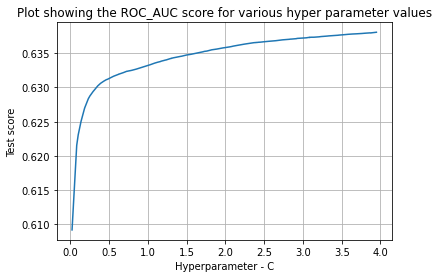

In [164]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [165]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_svd,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


LogisticRegression(C=3.947547746402069, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [166]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, 'lr_svd.csv')

![lr-svd](images/lr-svd.png)

## 5.4 Random Forest with SVD

In [167]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_svd,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.2s
/home/auw-mayank/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 24.5min finished


In [168]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
84,1000,25,5,2,0.854766
20,1000,25,3,2,0.852342
33,700,25,4,2,0.852278
22,200,25,4,10,0.851746
78,700,25,2,7,0.851114
85,1000,20,3,7,0.850986
62,500,25,3,5,0.850904
82,700,20,5,20,0.850789
79,500,25,1,10,0.848939
92,500,20,3,2,0.848604


In [169]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(1000, 5, 25, 2)

In [170]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_svd,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=5,
                       n_estimators=1000, n_jobs=-1, random_state=42)

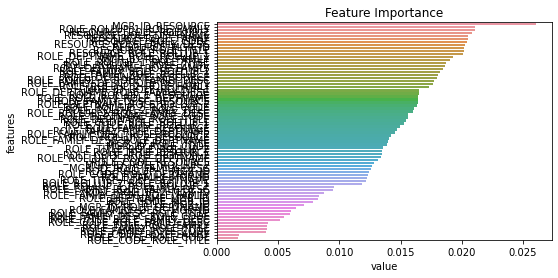

In [171]:
features=train_svd.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [172]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, 'rf_svd.csv')

![rf-svd](images/rf-svd.png)

## 5.5 Xgboost with SVD

In [173]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_svd,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/auw-mayank/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 50.8min finished


In [174]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
62,500,0.0663892,0.328153,9,0.375583,3,0.857269
18,1000,0.048135,0.665922,9,0.330898,2,0.856856
96,500,0.0979629,0.98664,7,0.891897,1,0.856098
44,1000,0.060484,0.606429,6,0.642032,2,0.855896
8,750,0.0686033,0.683264,6,0.304614,4,0.855817
97,750,0.232385,0.907694,6,0.374271,1,0.853594
49,500,0.160277,0.393098,8,0.636333,2,0.848866
80,1000,0.385564,0.905351,3,0.820639,1,0.848727
53,200,0.540096,0.928319,6,0.27956,1,0.847864
78,1000,0.576551,0.94023,6,0.943892,4,0.844565


In [175]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.375582952639944, 0.06638916390452139, 9, 3, 500, 0.32815266747473193)

In [176]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_svd,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.375582952639944, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.06638916390452139, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.32815266747473193, tree_method='exact',
              validate_parameters=1, verbosity=None)

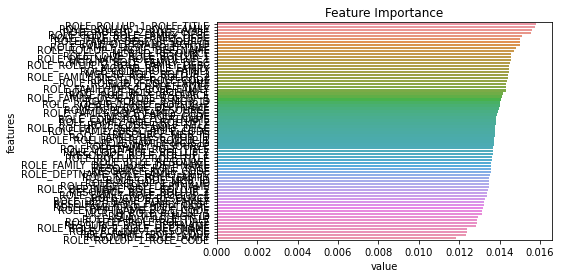

In [177]:
features=train_svd.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [178]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, 'xgb_svd.csv')

![xgb-svd](images/xgb-svd.png)

![kaggle-submission-svd](images/kaggle-submission-svd.png)

In [179]:
from prettytable import PrettyTable

x = PrettyTable(['Model', 'Feature', 'Private Score', 'Public Score'])
x.add_row(['KNN','svd', 0.79245, 0.78572])
x.add_row(['SVM', 'svd', 0.63648, 0.63806])
x.add_row(['Logistic Regression', 'svd', 0.63255, 0.63314])
x.add_row(['Random Forest', 'svd', 0.87119, 0.86924])
x.add_row(['Xgboost', 'svd', 0.86909, 0.86664])

print(x)

+---------------------+---------+---------------+--------------+
|        Model        | Feature | Private Score | Public Score |
+---------------------+---------+---------------+--------------+
|         KNN         |   svd   |    0.79245    |   0.78572    |
|         SVM         |   svd   |    0.63648    |   0.63806    |
| Logistic Regression |   svd   |    0.63255    |   0.63314    |
|    Random Forest    |   svd   |    0.87119    |   0.86924    |
|       Xgboost       |   svd   |    0.86909    |   0.86664    |
+---------------------+---------+---------------+--------------+


# Observations:

1. Tree based models works better than linear model
2. KNN is performing overall good

# We have to improve our model to reach into 5-10% on kaggle

In [180]:
# https://www.kaggle.com/mitribunskiy/tutorial-catboost-overview

In [181]:
# https://www.kaggle.com/prashant111/catboost-classifier-tutorial

# https://catboost.ai/

## CatBoost is a high-performance open source library for gradient boosting on decision trees


### About
CatBoost is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers, and is used for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks at Yandex and in other companies, including CERN, Cloudflare, Careem taxi. It is in open-source and can be used by anyone.


### Features

1. Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters
2. Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers. 
3. Reduce overfitting when constructing your models with a novel gradient-boosting scheme.
4. Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier

In [182]:
params = {
            'loss_function':'Logloss',
            'eval_metric':'AUC',
            'cat_features':list(range(train_data.shape[1])),
            'verbose':100,
            'random_seed':random_state
        }

In [183]:
clf= CatBoostClassifier(**params)
clf.fit(train_data,y_train)

Learning rate set to 0.045713
0:	total: 99.2ms	remaining: 1m 39s
100:	total: 2.33s	remaining: 20.7s
200:	total: 5.6s	remaining: 22.3s
300:	total: 8.79s	remaining: 20.4s
400:	total: 11.9s	remaining: 17.8s
500:	total: 15.2s	remaining: 15.2s
600:	total: 18.4s	remaining: 12.2s
700:	total: 21.7s	remaining: 9.27s
800:	total: 24.8s	remaining: 6.16s
900:	total: 28s	remaining: 3.08s
999:	total: 31.1s	remaining: 0us


In [184]:
predictions = clf.predict_proba(test_data)[:,1]

In [185]:
save_submission(predictions, 'catboost.csv')

![catboost](images/catboost.png)

## Catboost perform better than all our previous models and it's AUC score is much better than previous models so I am selecting this for predicting future data

In [186]:
# Save model on disk
pickle.dump(clf, open('models/catboost_model.pkl', 'wb'))